<a href="https://colab.research.google.com/github/leticiasdrummond/Notebooks_IT306/blob/main/20_%3F_Notebook_6_Efficiency_and_PV_Drummond_Performance_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Eficiência do Módulo e Métricas de Performance da Usina FV**

Nesta seção, baseada em Notebook_6, abordaremos:

1. Eficiência do Módulo com Variação de Irradiância
2. Eficiência do Módulo com Variação de Temperatura
3. Mapeamento de Eficiência do Módulo com Dados Reais
4. Aplicação de Métricas para Avaliação de Performance da Usina FV
   - Performance Ratio (PR)
   - Yield Final (Yf)
   - Yield Referencial (Yr)
   - Fator de Capacidade (FC)
5. Resumo das Análises: Dados de Entrada, Modelos pvlib e Resultados

In [42]:
# @title
# Instala a biblioteca pvlib, que é essencial para modelagem de sistemas fotovoltaicos
!pip install pvlib

# Importa as bibliotecas necessárias
# pvlib: A biblioteca principal para cálculos fotovoltaicos.
import pvlib
# pvsystem: Submódulo do pvlib para modelos de sistemas PV e cálculos de curva IV.
from pvlib import pvsystem
# numpy: Para operações numéricas, especialmente criação de arrays para gráficos.
import numpy as np
# pandas: Para manipulação e análise de dados, como DataFrames.
import pandas as pd
# matplotlib.pyplot: Para criar gráficos e visualizações.
import matplotlib.pyplot as plt
# scipy.constants: Para obter constantes físicas como a constante de Boltzmann e a carga elementar.
from scipy.constants import Boltzmann, elementary_charge

#### Modelagem da De Soto

In [43]:
# @title
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    # Ajusta o modelo de diodo único usando o método De Soto para encontrar parâmetros de referência
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc,
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref,
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    # Extraindo os parâmetros ajustados
    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    # Criando um DataFrame para armazenar os parâmetros ajustados
    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    # Preenchendo o DataFrame com os parâmetros ajustados
    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    # Calcula os parâmetros do modelo de diodo único para condições de operação usando o método De Soto
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad,
                                                          temp_cell,
                                                          alpha,
                                                          a_ref,
                                                          Ipv_ref,
                                                          Io_ref,
                                                          Rp_ref,
                                                          R_s,
                                                          EgRef,
                                                          dEgdT,
                                                          Gref,
                                                          Tref)
    # Organizando os parâmetros calculados em um dicionário
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    # Calculando a curva IV usando o modelo de diodo único
    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    # Gerando pontos de tensão para a curva IV
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    # Calculando os pontos de corrente correspondentes para a curva IV
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    # Retornando um dicionário contendo os pontos chave e os dados da curva IV
    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

#Constantes necessárias para a modelagem em STC
EgRef=1.121 # Energia da banda proibida para Silício Cristalino
dEgdT=- 0.0002677 # Coeficiente de temperatura para a banda proibida
Tref = 25 # Temperatura (°C) sob STC
Gref = 1000 # Irradiância (W/m²) sob STC
k = Boltzmann # Constante de Boltzmann
q = elementary_charge # Carga elementar

In [44]:
# @title
#Características do Módulo DM500M10RT-B60HBT/HST-U
Vmp = 37.66 #Voltage at Maximum Power
Imp = 13.30 #Current at Maximum Power
Voc = 44.70 #Open-Circuit Voltage
Isc = 14.22 #Short-Circuit Current
alpha = 0.048*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current
beta = (-0.25)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage
gamma = -0.29 #Perda de pot. com temperatura
Ns = 120 #Number of PV Cells in Series
A_c = 2.2113 #The Area of PV Module's Surface (m2)
eff_ref = 0.226 #eficiencia do modulo

In [45]:
# @title
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

In [46]:
# @title
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

Os 5 parâmetros do SDM em STC


,a_ref,Ipv_ref,Io_ref,Rp_ref,R_s
1,1.590812,14.239721,8.634588e-12,109.754665,0.150058


In [47]:
# @title
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

Pontos chave da Curva IV


{'i_sc': 14.220278530363343,
 'v_oc': 44.705419791252325,
 'i_mp': 13.299672311291761,
 'v_mp': 37.660570172698186,
 'p_mp': np.float64(500.8732423532945),
 'i_x': 14.016854971028307,
 'i_xx': 9.978013122511356}

### 1. Eficiência do Módulo com Variação de Irradiância

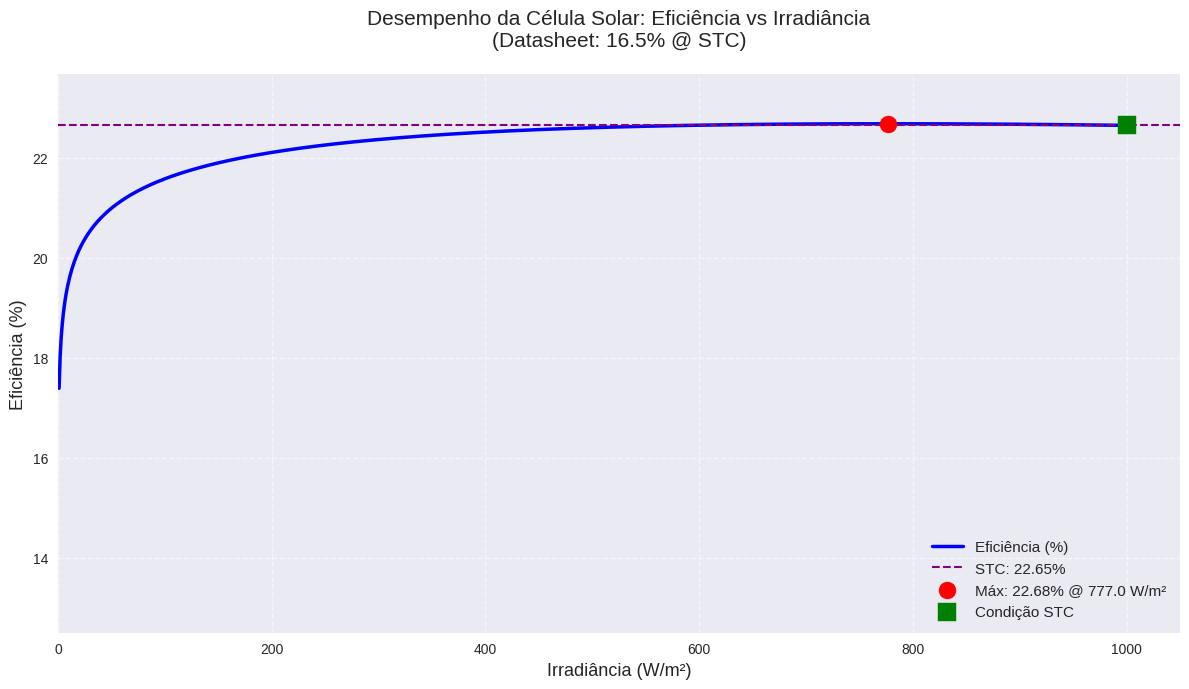

In [30]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados de irradiância variando de 1 a 1000 W/m², com temperatura constante em 25°C
irrad = np.linspace(1, 1000, 1000)
temp_cell = np.full(1000, 25)

# Calcula os parâmetros do modelo de diodo único para as condições de operação
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)

# Calcula a eficiência do módulo em porcentagem
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Já convertido para %

# Encontrando o ponto de máxima eficiência
max_eff_idx = np.argmax(eff)
max_eff = eff[max_eff_idx]
max_irrad = irrad[max_eff_idx]

# Ponto STC (Standard Test Conditions)
stc_idx = np.where(irrad >= 1000)[0][0]
stc_eff = eff[stc_idx]

# Plot principal: Eficiência vs Irradiância
plt.plot(irrad, eff, 'b-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor de eficiência STC para referência
plt.axhline(y=stc_eff, color='purple', linestyle='--', linewidth=1.5,
           label=f'STC: {stc_eff:.2f}%')

# Destaque para o ponto de máxima eficiência no gráfico
plt.scatter(max_irrad, max_eff, color='red', s=150, zorder=5,
           label=f'Máx: {max_eff:.2f}% @ {max_irrad:.1f} W/m²')

# Destaque para o ponto STC no gráfico
plt.scatter(1000, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Elementos gráficos: Título, rótulos dos eixos e grade
plt.title('Desempenho da Célula Solar: Eficiência vs Irradiância\n(Datasheet: 16.5% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais do gráfico: Limites dos eixos e legenda
plt.xlim(0, 1050)
plt.ylim(12.5, max(16.5, max_eff)+1)  # Considerando o valor do datasheet
# Correção do erro: alterado 'down right' para 'lower right'
plt.legend(loc='lower right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

### 2. Eficiência do Módulo com Variação de Temperatura

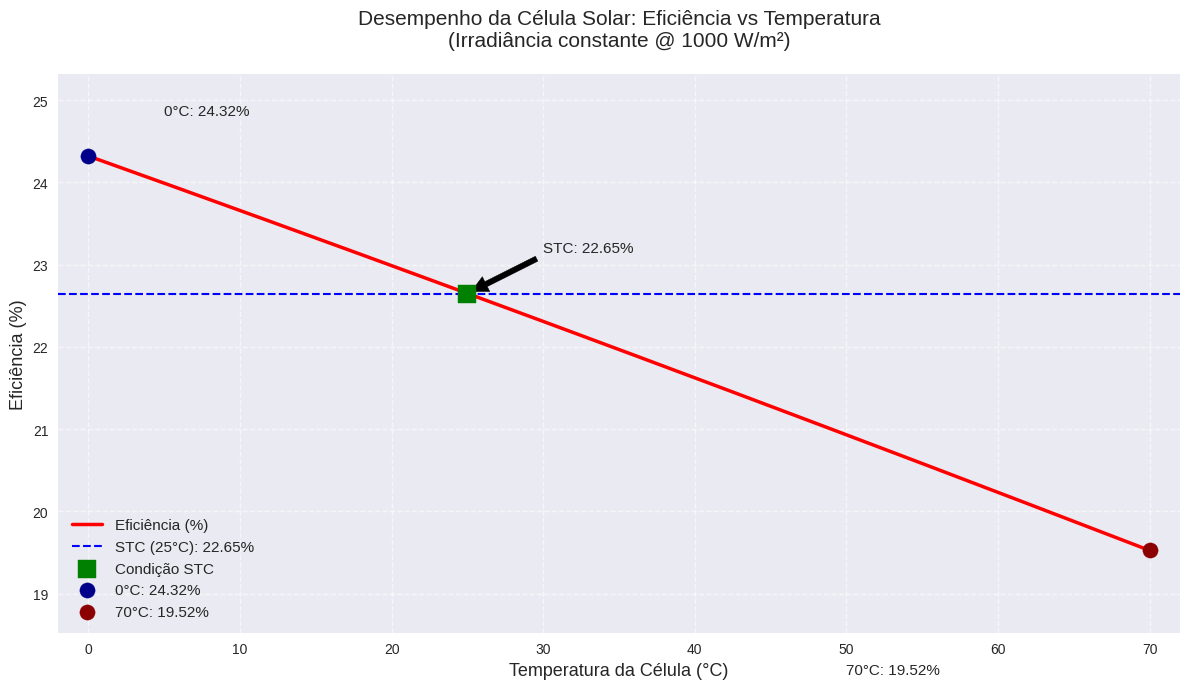

In [31]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados - Irradiância fixa e temperatura variável
irrad = np.full(1000, 1000)  # 1000 W/m² constante
temp_cell = np.linspace(0, 70, 1000)  # Temperatura de 0 a 70°C

# Cálculo dos parâmetros
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                             Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                             method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Encontrando pontos importantes
stc_temp = 25  # Temperatura STC
stc_idx = np.abs(temp_cell - stc_temp).argmin()
stc_eff = eff[stc_idx]

# Correção do erro: Acessar os elementos usando a posição inteira
min_temp_eff = eff.iloc[0]  # Eficiência em 0°C
max_temp_eff = eff.iloc[len(eff) - 1]  # Eficiência em 70°C

# Plot principal
plt.plot(temp_cell, eff, 'r-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='blue', linestyle='--', linewidth=1.5,
           label=f'STC (25°C): {stc_eff:.2f}%')

# Destaque para ponto STC
plt.scatter(stc_temp, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Destaque para pontos extremos
plt.scatter(temp_cell[0], min_temp_eff, color='darkblue', s=120, zorder=5,
           label=f'0°C: {min_temp_eff:.2f}%')
plt.scatter(temp_cell[-1], max_temp_eff, color='darkred', s=120, zorder=5,
           label=f'70°C: {max_temp_eff:.2f}%')

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Temperatura\n(Irradiância constante @ 1000 W/m²)',
         fontsize=15, pad=20)
plt.xlabel('Temperatura da Célula (°C)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Anotações
plt.annotate(f'STC: {stc_eff:.2f}%', xy=(stc_temp, stc_eff),
            xytext=(stc_temp+5, stc_eff+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=11)

plt.annotate(f'0°C: {min_temp_eff:.2f}%', xy=(temp_cell[0], min_temp_eff),
            xytext=(temp_cell[0]+5, min_temp_eff+0.5),
            fontsize=11)

plt.annotate(f'70°C: {max_temp_eff:.2f}%', xy=(temp_cell[-1], max_temp_eff),
            xytext=(temp_cell[-1]-20, max_temp_eff-1.5),
            fontsize=11)

# Configurações finais
plt.xlim(-2, 72)
plt.ylim(min(eff)-1, max(eff)+1)
plt.legend(loc='lower left', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

### 3. Mapeamento de Eficiência do Módulo com Dados Reais

In [37]:
# @title
df_weather_2021.keys()

Index(['Unnamed: 0', 'Year', 'DOY', 'MST', 'dni', 'dhi',
       'Global Horiz (tracker) [W/m^2]', 'ghi', 'Temp CHP1 [deg C]',
       'Temp CM22 (tracker) [deg C]', 'Temp CM22 (platform) [deg C]',
       'CR1000 Temp [deg C]', 'CR1000 Battery [VDC]', 'temp_air',
       'Rel Humidity [%]', 'Station Pressure [mBar]', 'wind_speed',
       'Avg Wind Direction @ 3m [deg from N]', 'Peak Wind Speed @ 3m [m/s]',
       'Zenith Angle [degrees]', 'Azimuth Angle [degrees]'],
      dtype='object')

In [38]:
# @title
# Seleciona as colunas relevantes usando os nomes renomeados
df_weather = df_weather_2021[['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed', 'Station Pressure [mBar]']]

# Renomeia a coluna de pressão para consistência
df_weather = df_weather.rename(columns={'Station Pressure [mBar]': 'air_pressure'})

In [39]:
# @title
df_weather

,ghi,dhi,dni,temp_air,wind_speed,air_pressure
2021-01-01 00:00:00-07:00,-1.90242,0.0,-0.375696,8.53,0.405,922.557
2021-01-01 00:01:00-07:00,-1.90814,0.0,-0.433495,8.54,0.317,922.564
2021-01-01 00:02:00-07:00,-1.92528,0.0,-0.433495,8.54,0.000,922.584
2021-01-01 00:03:00-07:00,-1.82815,0.0,-0.433495,8.56,0.000,922.590
2021-01-01 00:04:00-07:00,-1.84529,0.0,-0.433495,8.59,0.016,922.586
...,...,...,...,...,...,...
2021-12-31 23:55:00-07:00,-1.37110,0.0,-0.433489,10.21,0.894,920.591
2021-12-31 23:56:00-07:00,-1.37110,0.0,-0.455163,10.27,0.127,920.629
2021-12-31 23:57:00-07:00,-1.37110,0.0,-0.455163,10.31,0.063,920.631
2021-12-31 23:58:00-07:00,-1.37110,0.0,-0.433488,10.32,0.016,920.665


<Axes: >

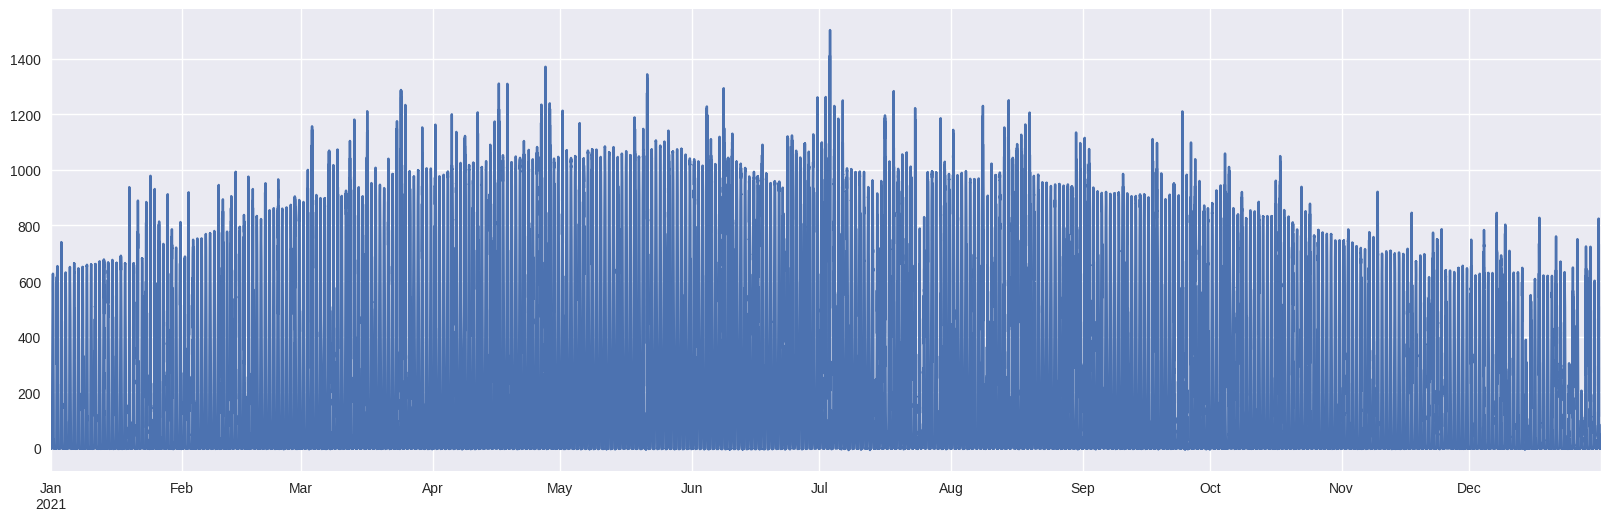

In [40]:
# @title
df_weather['ghi'].plot(figsize=(20,6))

In [41]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

loc = pvlib.location.Location(
    latitude=32.22969,
    longitude=-110.95534,
    altitude=786,
    tz='Etc/GMT-7' # ou 'America/Los_Angeles' (dependendo dos seus dados)
)


solpos = loc.get_solarposition(df_weather.index)

surface_tilt = 20
surface_azimuth = 180
solar_zenith = solpos['zenith']
solar_azimuth = solpos['azimuth']
dni = df_weather['dni']
ghi = df_weather['ghi']
dhi = df_weather['dhi']
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude = altitude)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

POA_Irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt,
                                                  surface_azimuth,
                                                  solar_zenith,
                                                  solar_azimuth,
                                                  dni,
                                                  ghi,
                                                  dhi,
                                                  dni_extra=dni_extra,
                                                  airmass=airmass,
                                                  albedo=0.25,
                                                  surface_type=None,
                                                  model='isotropic', #'isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez', 'perez-driesse'
                                                  model_perez='allsitescomposite1990') #Used only for Perez Model)
# Dados
poa = POA_Irradiance['poa_global']
ghi = df_weather['ghi']

# 1. Plot comparativo temporal aprimorado
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Plot das séries com preenchimento entre elas
poa.plot(label='POA Global (Plano do Arranjo)', color='#FF7F0E', linewidth=1.8, ax=ax)
ghi.plot(label='GHI (Global Horizontal)', color='#1F77B4', linewidth=1.8, ax=ax)
plt.fill_between(poa.index, poa, ghi, where=(poa >= ghi),
                facecolor='orange', alpha=0.3, interpolate=True)
plt.fill_between(poa.index, poa, ghi, where=(poa < ghi),
                facecolor='blue', alpha=0.3, interpolate=True)

# Configurações do gráfico
plt.title('Comparação entre Irradiância no Plano do Arranjo (POA) e Global Horizontal (GHI)',
          fontsize=14, pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Irradiância (W/m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Adicionando anotações de valores máximos
max_poa = poa.max()
max_ghi = ghi.max()
plt.annotate(f'Max POA: {max_poa:.1f} W/m²',
             xy=(poa.idxmax(), max_poa), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Max GHI: {max_ghi:.1f} W/m²',
             xy=(ghi.idxmax(), max_ghi), xytext=(10, -25),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

# 2. Cálculo de métricas básicas
metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# 3. Exibição das métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f}"))

# 4. Análise da razão diária POA/GHI (se houver dados suficientes)
if len(poa) > 24:  # Pelo menos 1 dia de dados horários
    daily_poa = poa.resample('D').sum()/1000
    daily_ghi = ghi.resample('D').sum()/1000
    daily_ratio = daily_poa/daily_ghi

    plt.figure(figsize=(15, 6))
    daily_ratio.plot(color='green', linewidth=1.5)
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

NameError: name 'altitude' is not defined

NameError: name 'poa' is not defined

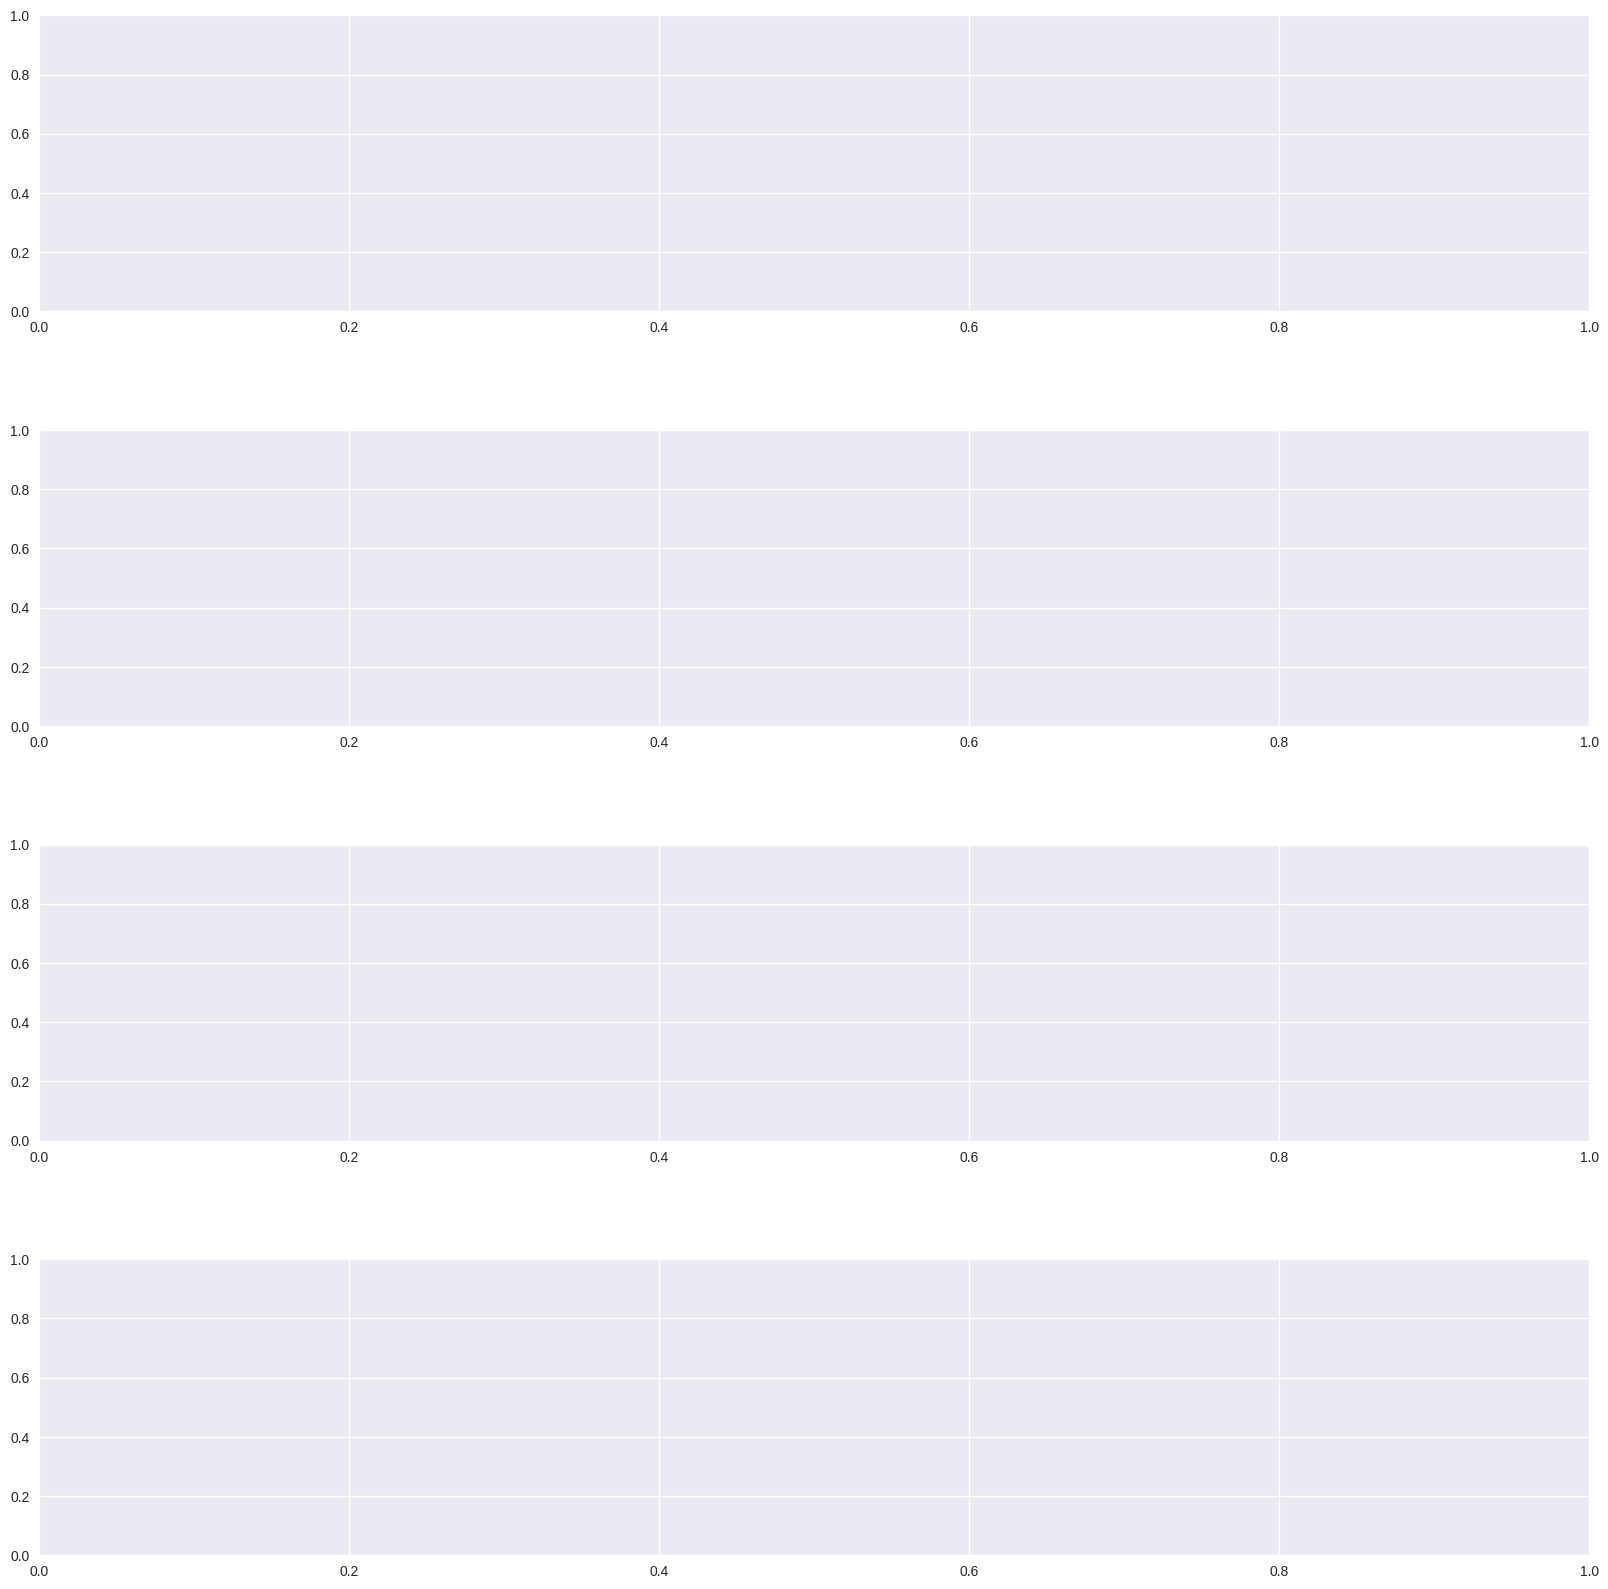

In [48]:
# @title
#Influência de Parâmetros para a Modelagem de Temperatura
#Pedir para plotarem os gráficos com
import matplotlib.pyplot as plt

# Criar figura com 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

# Ajustar espaçamento entre subplots
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: poa.plot()
poa.plot(ax=axes[0], title='POA (Plane of Array) Irradiance', color='orange')
axes[0].set_ylabel('Irradiance (W/m²)')
axes[0].grid(True)

# Gráfico 2: Temperatura do ar
df_weather['temp_air'].plot(ax=axes[1], title='Air Temperature', color='red')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

# Gráfico 3: Velocidade do vento
df_weather['wind_speed'].plot(ax=axes[2], title='Wind Speed', color='blue')
axes[2].set_ylabel('Speed (m/s)')
axes[2].grid(True)

# Gráfico 4: Temperatura da célula PV
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = df_weather['temp_air'], wind_speed = df_weather['wind_speed'], a = -3.47, b = -0.0594, deltaT = 3, irrad_ref=1000.0)
PV_Cell_Temperature_Sandia.plot(ax=axes[3], title='PV Cell Temperature (Sandia Model)', color='purple')
axes[3].set_ylabel('Temperature (°C)')
axes[3].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

In [ ]:
# @title
irrad = poa

temp_cell = PV_Cell_Temperature_Sandia

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)

results['Key_Points']['p_mp'].plot(figsize=(20,6), title='Potência em kW')

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(20, 7))

# Dados
irrad = poa
temp_cell = PV_Cell_Temperature_Sandia

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Criando o scatter plot com mapa de cores baseado na temperatura
scatter = plt.scatter(
    irrad,
    eff,
    c=temp_cell,  # Cor varia com a temperatura
    cmap='plasma',  # Mapa de cores (pode usar 'plasma', 'inferno', etc.)
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

# Barra de cores (legend)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperatura da Célula (°C)', fontsize=12)

# Linha horizontal no valor STC
plt.axhline(y=22.6, color='black', linestyle='--', linewidth=1.5,
           label=f'STC: {22.6:.2f}%')

# Elementos gráficos
plt.title('Desempenho do Módulo FV com Dados Meteorológicos Medidos: Eficiência vs Irradiância\n(Datasheet: 22.6% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(16.5, np.max(eff)) + 1)
plt.legend(loc='upper right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

### 4. Aplicação de Métricas para Avaliação de Performance da Usina FV

In [ ]:
# @title
print('Curva IV em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'])
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'])
plt.xlabel('Voltage (V)') # Added x-label
plt.ylabel('Current (A)') # Added y-label
plt.title('Curva IV do Módulo DM500M10RT-B60HBT/HST-U em STC', fontsize=14) # Added title
plt.show()
# Coordenadas do ponto de máxima potência
v_mp = results['Key_Points']['v_mp']
i_mp = results['Key_Points']['i_mp']

# Destaca o MPP no gráfico
plt.scatter(v_mp, i_mp, color='red', label='Ponto de Máxima Potência (MPP)')

In [ ]:
# @title
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather_2021.head(3)

#### Performance Ratio (PR)

#### Yield Final (Yf)

3. Mapeamento de Eficiência do Módulo com Dados Reais

4. Aplicação de Métricas para Avaliação de Performance da Usina FV

- Detalhe: Precisamos converter a potência para energia! Como a resolução de tempo que estamos usando nesse tempo é minuto a minuto, devemos dividir a potência por 60 (já que uma hora é composta por 60 minutos). Em casos de datasets com resolução de 15 em 15 min é a mesma história, mas a divisão é por 4, já que 15 min equivalem 1/4 de uma hora.

- Performance Ratio

O performance ratio (PR) é a métrica mais conhecida para avaliação de performance de uma usina, ou seja, para medir a sua "saúde". Essa que vamos usar no projeto é a padrão da norma IEC 61724-1. Existem variações do PR, considerando perdas conhecidas e esperadas na nossa modelagem, dando espaço para investigação de outras perdas que não foram possíveis serem estimadas.

Por definição, o PR é a comparação da Eficiência medida do sistema em relação à eficiência esperada. Contudo, para fins práticos, o rearranjo matemático nos permite proporcionar uma equação mais direta, onde medimos a geração DC ou AC (Na prática usamos a geração AC mesmo) e comparamos com o cenário modelado (Potência em STC do sistema vezes as horas de sol pleno).

In [ ]:
# @title
#PR ao longo do tempo
Energy = results['Key_Points']['p_mp']/60

Irradiation = irrad/60

PR = Energy/(Irradiation/1000*Vmp*Imp)
PR.plot(figsize=(20,6), title='Performance Ratio (PR) - Potência Normalizada')

In [ ]:
# @title
#PR Total. Pode ser extendida para período mensal e anual.
PR = Energy.sum()/(Irradiation.sum()/1000*Vmp*Imp)
PR

- Yield Final (Yf)

Essa métrica refere-se à quantidade de horas em que a usina está gerando a nível STC (potência do sistema em sob STC)

In [ ]:
# @title
Yf = Energy/(Vmp*Imp)
Yf.plot(figsize=(20,6), label = 'Yield Final (Horas)')
plt.legend()

In [ ]:
# @title
#Total de Horas em que o Sistema Gerou em Potência de STC
Yf = Energy.sum()/(Vmp*Imp)
Yf

- Yield Referencial (Yr)

Aqui é o cálculo para determinar a quantidade de horas de sol pleno no plano do módulo. Vocês podem adaptar para GHI quanto para POA.

In [ ]:
# @title
Yr = Irradiation/1000
Yr.plot(figsize=(20,6), label = 'Yield Referencial ou Horas de Sol Pleno (horas)')
plt.legend()

In [ ]:
# @title
#Total de Horas de Sol Pleno
Yr.sum()

- Fator de Capacidade (FC)

Fator de Capacidade é uma métrica usada para verificar o quanto de energia está sendo gerado, em STC, em comparação com um cenário em que a usina estivesse gerando 24 horas em STC. É uma métrica usada até mesmo para comparar com outras fontes de energia renovável, como a eólica.

In [ ]:
# @title
Numero_de_Dias = 7 #Nesse exemplo usamos para 7 dias, devido ao período considerado para o presente exemplo, podendo ser adaptado pela quantidade de dias que quiser: Semanas, Meses, Anos...
FC = Energy/(Vmp*Imp*Numero_de_Dias*24)
FC.plot(figsize=(20,6), label = 'Fator de Capacidade (Adimensional)')
plt.legend()

In [ ]:
# @title
#A unidade é mais conhecida em Percentual
FC.sum()*100